# Klasifikasi Kelayakan Kredit Komputer – Decision Tree  
Notebook ini mereplikasi pipeline pada `train_decision_tree.py` secara interaktif.

In [8]:
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay)

In [7]:
import pandas as pd
df = pd.read_csv("../data/dataset_buys_comp.csv")

display(df.head())
print(df.shape)

,Age,Income,Student,Credit_Rating,Buys_Computer
0,Tua,Tinggi,Ya,Buruk,0
1,Paruh Baya,Tinggi,Ya,Baik,1
2,Paruh Baya,Rendah,Tidak,Buruk,1
3,Tua,Rendah,Tidak,Baik,1
4,Tua,Rendah,Ya,Baik,1


(1000, 5)


In [9]:
display(df.describe(include="all"))
print("Missing values per kolom:")
print(df.isna().sum())
# Bar/hist sederhana (opsional)
# df["Age"].hist(); plt.show()

,Age,Income,Student,Credit_Rating,Buys_Computer
count,1000,1000,1000,1000,1000.000000
unique,3,3,2,2,NaN
top,Paruh Baya,Tinggi,Ya,Buruk,NaN
freq,346,347,510,526,NaN
mean,NaN,NaN,NaN,NaN,0.669000
std,NaN,NaN,NaN,NaN,0.470809
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,1.000000


Missing values per kolom:
Age              0
Income           0
Student          0
Credit_Rating    0
Buys_Computer    0
dtype: int64


In [10]:
X = df.drop("Buys_Computer", axis=1)
y = df["Buys_Computer"]

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if X[c].dtype != "object"]

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

preprocess = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(random_state=42))
])

param_grid = {
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [None, 3, 5, 7, 10],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy")
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

Best params: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best CV accuracy: 0.8074999999999999


              precision    recall  f1-score   support

           0       0.67      0.85      0.75        66
           1       0.91      0.79      0.85       134

    accuracy                           0.81       200
   macro avg       0.79      0.82      0.80       200
weighted avg       0.83      0.81      0.81       200



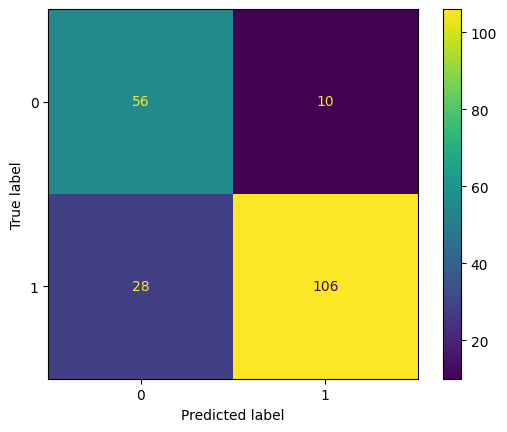

ROC‑AUC: 0.9292175486205339


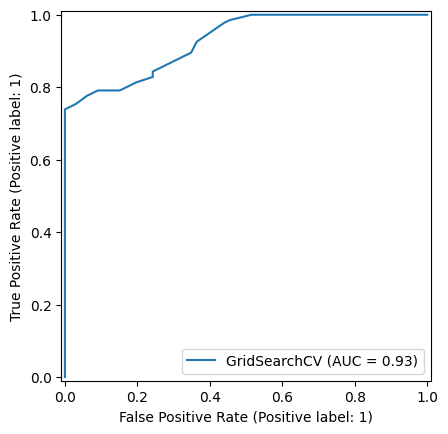

In [12]:
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test)
plt.show()

if len(y.unique()) == 2:
    y_prob = grid.predict_proba(X_test)[:, 1]
    print("ROC‑AUC:", roc_auc_score(y_test, y_prob))
    RocCurveDisplay.from_estimator(grid, X_test, y_test)
    plt.show()

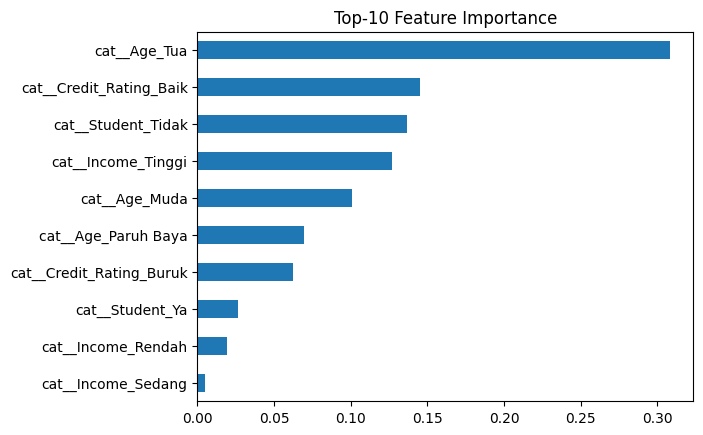

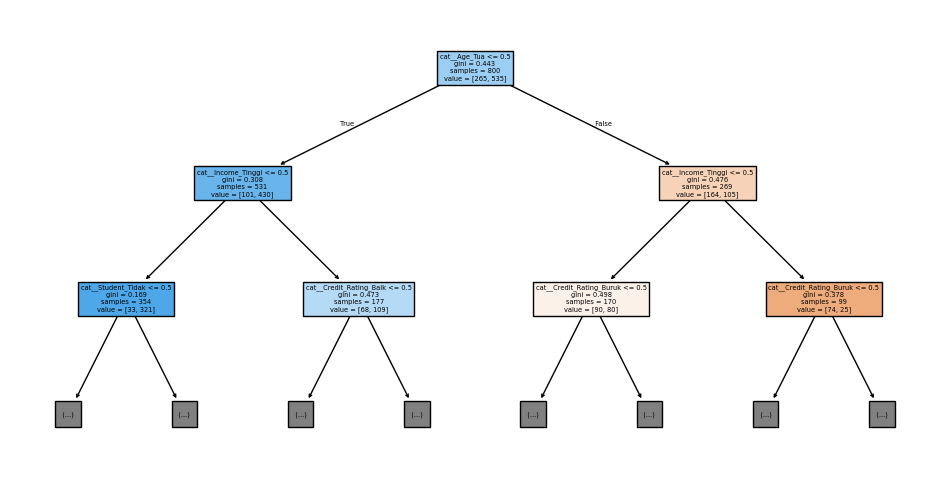

In [13]:
model = grid.best_estimator_.named_steps["model"]
importances = pd.Series(model.feature_importances_,
                        index=grid.best_estimator_.named_steps["preprocess"]
                              .get_feature_names_out())
importances.sort_values(ascending=False).head(10).plot.barh()
plt.gca().invert_yaxis(); plt.title("Top‑10 Feature Importance"); plt.show()

plt.figure(figsize=(12,6))
plot_tree(model, max_depth=2, filled=True,
          feature_names=importances.index.tolist())
plt.show()

In [14]:
import joblib, datetime, os
joblib.dump(grid.best_estimator_, "model_dt.pkl")
print("Model disimpan:", os.path.abspath("model_dt.pkl"),
      "pada", datetime.datetime.now())

Model disimpan: c:\Users\Arkan Raihan\Desktop\Decision Tree\notebooks\model_dt.pkl pada 2025-04-24 18:11:22.363479
